In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [1]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Utilities import Constants as Const
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

h_red = Const.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
h = Const.Planck_ev_ps*1e3 # h in eV*fs

In [3]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.YamboCalculator(rr)
#code.global_options()

Initialize a Yambo calculator with scheduler direct


In [112]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 2
ntasks_per_node = 16 #16
cpus_per_task = 2 #2
omp_num_threads = 2 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='slownodes', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 2,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'slownodes',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

We make usage of the core databases generated by Andrea and located in 

In [19]:
core_dbs = '/work/marini/TMDs/WSe2/Ralph/SAVEs_and_CORE_DBs'
os.listdir(core_dbs)

['12x12x3',
 '16x16x4',
 '9x9x1',
 'PW.gitlab',
 'known_hosts',
 '9x9x1_p',
 '12x12x3_p',
 '9x9x1_bkp']

# Analysis of the absorption spectrum in the equilibrium regime

We compute the equilibrium absorption spectrum in both the ip and BSE framework.

## IP analysis

The systems has 52 electrons and an equal numbers of full bands due to the SOC.

We compute the ip absorption spectrum for various k-samplings. All the computations
are performed using the bands from 42 to 62.

In [6]:
run_path = 'EQ_ABS_IP'
kpoints = ['9x9x1','12x12x3','16x16x4']

In [10]:
eta = 0.1 # damping value for both conduction and valence bands (eV) 
energy_range = [0,12] # energy range in eV
energy_step = 500 # number of energy step
elec_field = [1.,0.,0.]
bands_trans = [42,62]
scissor = 0. # 

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    source_dir = os.path.join(core_dbs,k,'SAVE')
    run_dir = os.path.join(run_path,k)
    Tools.init_yambo_run_dir(source_dir,run_dir=run_dir)
    
    inp = I.YamboInput('yambo -o c',folder=run_dir)
    inp.set_array_variables(LongDrXd = elec_field,XfnQP_E=[scissor,1.,1.]) # electric field / scissor
    inp.set_array_variables(units='eV',DmRngeXd=[eta/2,eta/2],EnRngeXd=energy_range) # damping / energy range
    inp.set_array_variables(ETStpsXd =energy_step, BndsRnXd=bands_trans,QpntsRXd=[1,1]) # energy step / bands or transitions / momentum transfer
    idd = 'ip_abs-bnds_%s-%s_kpoints_%s'%(bands_trans[0],bands_trans[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

Initialize a Dataset with 1 parallel tasks
SAVE folder already present in EQ_ABS_IP/9x9x1. No operations performed.
SAVE folder already present in EQ_ABS_IP/12x12x3. No operations performed.
SAVE folder already present in EQ_ABS_IP/16x16x4. No operations performed.


In [12]:
#study.runs[0]

In [13]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of ip_abs-bnds_42-62_kpoints_9x9x1
Task [0] ended 
 
Run the task [1] 
Skip the run of ip_abs-bnds_42-62_kpoints_12x12x3
Task [1] ended 
 
Run the task [2] 
Skip the run of ip_abs-bnds_42-62_kpoints_16x16x4
Task [2] ended 
 


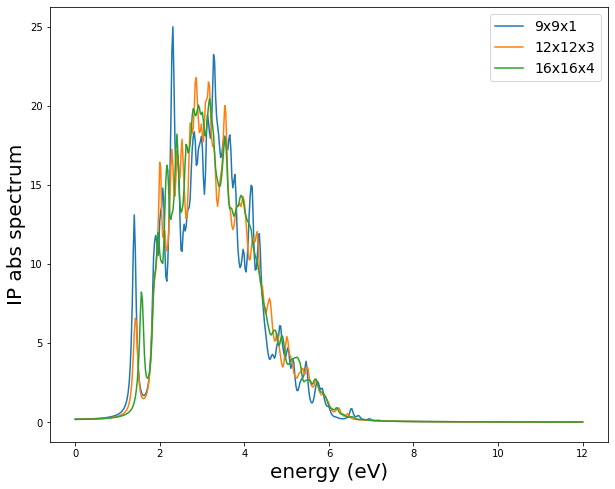

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,k in enumerate(kpoints):
    data = results[ind].data['eps_q1_ip']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,eps_im,label=k)
ax.set_ylabel('IP abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

## BSE Analysis

We analyze the equilibrium absorption spectrum in the BSE framework.

Also in this case we test the convergence of the spectrum w.r.t the $k$-points sampling.

### Computation of the static screening

We compute the static inverse dielectric function that is needed to compute the effective potential.

As a first step we adopt the parameters provided by the analysis performed by Andrea.

In [42]:
run_path = 'EQ_ABS_BSE'
kpoints = ['9x9x1','12x12x3','16x16x4']

In [22]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

NGsBlkXs = 200 # (RL) G size of the response function
NGsBlkXs_units = 'RL'
BndsRnXs = [1,100] # Polarization function bands
elec_field = [1.,0.,0.]

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    source_dir = os.path.join(core_dbs,k,'SAVE')
    run_dir = os.path.join(run_path,k)
    Tools.init_yambo_run_dir(source_dir,run_dir=run_dir,overwrite_if_found=False,make_link=True)
    inp = I.YamboInput('yambo -X s',folder=run_dir)
    inp.set_array_variables(units=NGsBlkXs_units,NGsBlkXs=NGsBlkXs)
    inp.set_array_variables(BndsRnXs=BndsRnXs,LongDrXs=elec_field)
    inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.4.4.2') # for 1 node on ismhpc (with 32 mpi and 1 omp per node)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.32') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
    inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
    idd = 'em1s-ngsblkxs_%s-bndsrnxs_%s-kpoints_%s'%(NGsBlkXs,BndsRnXs[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

16 2
Initialize a Dataset with 1 parallel tasks
Create folder path EQ_ABS_BSE/9x9x1
Create a symlink of /work/marini/TMDs/WSe2/Ralph/SAVEs_and_CORE_DBs/9x9x1/SAVE in EQ_ABS_BSE/9x9x1
Executing command: cd EQ_ABS_BSE/9x9x1; yambo


In [23]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'EQ_ABS_BSE/9x9x1',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'yambo -X s',
  'folder': 'EQ_ABS_BSE/9x9x1',
  'filename': 'yambo.in',
  'arguments': ['em1s'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'NGsBlkXs': [200, 'RL'],
   'Chimod': 'HARTREE',
   'XTermKind': 'none',
   'BndsRnXs': [[1, 100], ''],
   'LongDrXs': [[1.0, 0.0, 0.0], '']}},
 'name': 'em1s-ngsblkxs_200-bndsrnxs_100_kpoints_9x9x1'}

In [24]:
results = study.run(selection=[0])

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo -F em1s-ngsblkxs_200-bndsrnxs_100_kpoints_9x9x1.in -J em1s-ngsblkxs_200-bndsrnxs_100_kpoints_9x9x1 -C em1s-ngsblkxs_200-bndsrnxs_100_kpoints_9x9x1
slurm submit:  cd EQ_ABS_BSE/9x9x1 ; sbatch job_em1s-ngsblkxs_200-bndsrnxs_100_kpoints_9x9x1.sh
computation em1s-ngsblkxs_200-bndsrnxs_100_kpoints_9x9x1 is running...
computation em1s-ngsblkxs_200-bndsrnxs_100_kpoints_9x9x1 ended

        There are no o-* files.
        Maybe you have performed a computation that does not create any output file or wait_end_run
        and/or the dry_run option are active.
        Otherwise a possible error has occured during the computation
        
Run performed in 01m-44s
Task [0] ended 
 


## BSE calculations

In [92]:
run_path = 'EQ_ABS_BSE'
kpoints = ['9x9x1','12x12x3','16x16x4']

First we test the convergence of the spectrum w.r.t the value of the BSENGBlk variable.

We perform this analysis in the 9x9x1 sampling.

In [93]:
BSENGBlk = [50,100,150] # (RL) G size of the response function
BndsRnXs = [1,100] # Polarization function bands
elec_field = [1.,0.,0.]
BSEBands = [42,62]
energy_range = [0,6] # eV
energy_step = 500
damping = [0.05,0.05] # eV
scissor = 0.35 

k = kpoints[0]
run_dir = os.path.join(run_path,k)
study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -o b -k sex -y h',folder=run_dir)
inp.set_array_variables(BSEBands=BSEBands,BLongDir=elec_field)
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
inp.set_array_variables(BEnSteps=energy_step,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='RL',BSENGexx=6293)
inp.set_scalar_variables(DIP_CPU='4.4.2',DIP_ROLEs='v.c.k',BS_CPU='8.4',BS_ROLEs= 'eh.k')
for bsengblk in BSENGBlk:
    inp.set_array_variables(units='RL',BSENGBlk=bsengblk)
    idd = 'bse-bsengblk_%s-bsebands_%s-%s-kpoints_%s'%(bsengblk,BSEBands[0],BSEBands[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                 jobname=[idd,'em1s-ngsblkxs_200-bndsrnxs_100-kpoints_%s'%k])

Initialize a Dataset with 1 parallel tasks


In [97]:
#study.runs[2]

In [98]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
run command: mpirun -np 32 yambo -F bse-bsengblk_50-bsebands_42-62-kpoints_9x9x1.in -J "bse-bsengblk_50-bsebands_42-62-kpoints_9x9x1,em1s-ngsblkxs_200-bndsrnxs_100-kpoints_9x9x1" -C bse-bsengblk_50-bsebands_42-62-kpoints_9x9x1
slurm submit:  cd EQ_ABS_BSE/9x9x1 ; sbatch job_bse-bsengblk_50-bsebands_42-62-kpoints_9x9x1.sh
computation bse-bsengblk_50-bsebands_42-62-kpoints_9x9x1 is running...
computation bse-bsengblk_50-bsebands_42-62-kpoints_9x9x1 ended
Run performed in 03m-22s
Task [0] ended 
 
Run the task [1] 
run command: mpirun -np 32 yambo -F bse-bsengblk_100-bsebands_42-62-kpoints_9x9x1.in -J "bse-bsengblk_100-bsebands_42-62-kpoints_9x9x1,em1s-ngsblkxs_200-bndsrnxs_100-kpoints_9x9x1" -C bse-bsengblk_100-bsebands_42-62-kpoints_9x9x1
slurm submit:  cd EQ_ABS_BSE/9x9x1 ; sbatch job_bse-bsengblk_100-bsebands_42-62-kpoints_9x9x1.sh
computation bse-bsengblk_100-bsebands_42-62-kpoints_9x9x1 is 

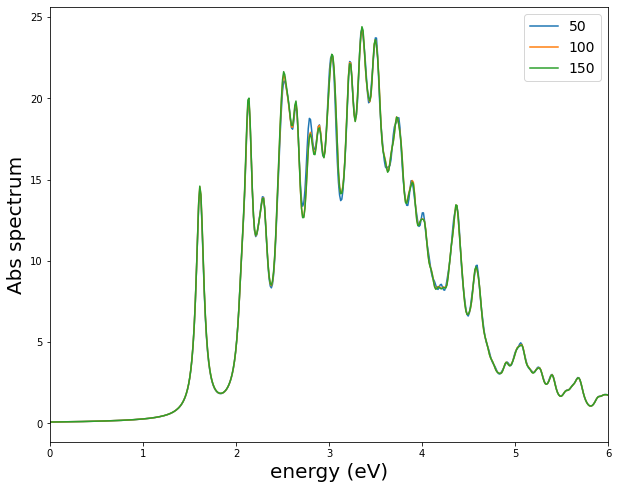

In [99]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,b in enumerate(BSENGBlk):
    data = results[ind].data['eps_q1_haydock_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,eps_im,label='%s'%b) 
ax.set_xlim(0,6)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

In [113]:
BSENGBlk = 50 #150 #200 # (RL) G size of the response function
BndsRnXs = [1,100] # Polarization function bands
elec_field = [1.,0.,0.]
BSEBands = [42,62]
energy_range = [0,6] # eV
energy_step = 500
damping = [0.05,0.05] # eV
scissor = 0.35 

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    run_dir = os.path.join(run_path,k)
    inp = I.YamboInput('yambo -o b -k sex -y h',folder=run_dir)
    inp.set_array_variables(BSEBands=BSEBands,BLongDir=elec_field)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BEnSteps=energy_step,KfnQP_E=[scissor,1.,1.])
    inp.set_array_variables(units='RL',BSENGBlk=BSENGBlk,BSENGexx=6293) #,FFTGvecs=6269
    inp.set_scalar_variables(DIP_CPU='4.4.2',DIP_ROLEs='v.c.k',BS_CPU='8.4',BS_ROLEs= 'eh.k')
    idd = 'bse-bsengblk_%s-bsebands_%s-%s-kpoints_%s'%(BSENGBlk,BSEBands[0],BSEBands[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                 jobname=[idd,'em1s-ngsblkxs_200-bndsrnxs_100-kpoints_%s'%k,'ndb_bse'])

Initialize a Dataset with 1 parallel tasks


In [115]:
#study.runs[2]

In [116]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of bse-bsengblk_50-bsebands_42-62-kpoints_9x9x1
Task [0] ended 
 
Run the task [1] 
Skip the run of bse-bsengblk_50-bsebands_42-62-kpoints_12x12x3
Task [1] ended 
 
Run the task [2] 
delete job_out script: EQ_ABS_BSE/16x16x4/job_bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4.out
delete folder: EQ_ABS_BSE/16x16x4/bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4
run command: mpirun -np 32 yambo -F bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4.in -J "bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4,em1s-ngsblkxs_200-bndsrnxs_100-kpoints_16x16x4,ndb_bse" -C bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4
slurm submit:  cd EQ_ABS_BSE/16x16x4 ; sbatch job_bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4.sh
computation bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4 is running...
computation bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4 ended
Run performed in 03h-56m
Task [2] ended 
 


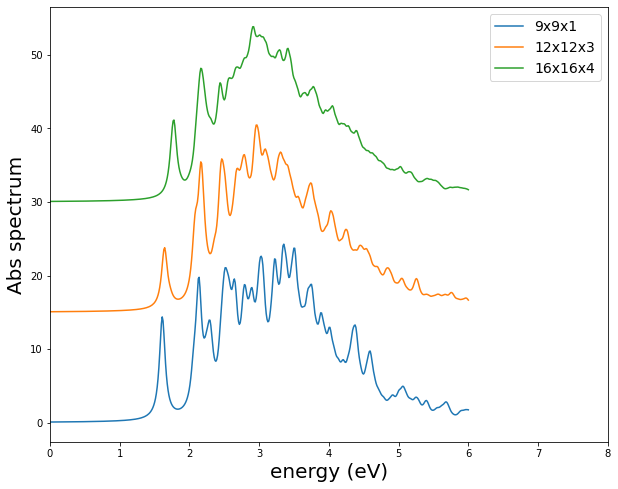

In [121]:
fig, ax = plt.subplots(figsize=(10, 8))

#ax.plot(ip_energy,ip_eps_im,label='IP',linestyle='--',linewidth=2)
for ind,k in enumerate(kpoints):
    data = results[ind].data['eps_q1_haydock_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,15*ind+eps_im,label='%s'%k) 
ax.set_xlim(0,8)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

## Comparison with experimental data

In [122]:
alpha_exp = 'Experiment/alpha.dat'
data_exp = np.loadtxt(alpha_exp,delimiter=',').T
energy_exp,abs_exp = data_exp

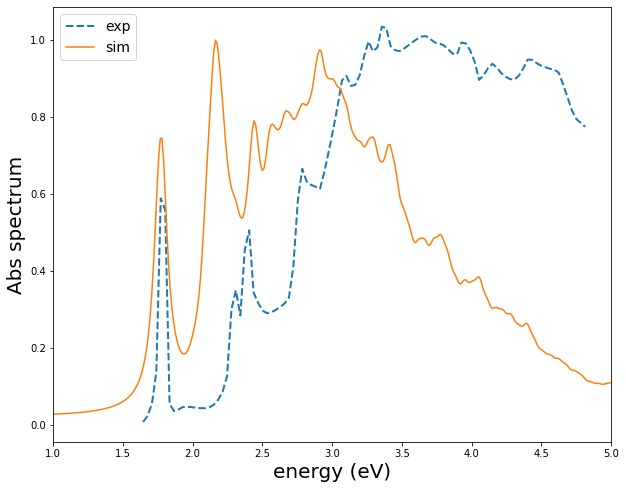

In [134]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(0.16+energy_exp,abs_exp,label='exp',linestyle='--',linewidth=2)

data = results[2].data['eps_q1_haydock_bse']
energy = data['energy'][80:] # starts from 1 eV
eps_im = data['eps_imag'][80:]
alpha = eps_im/energy
#alpha = np.true_divide(eps_im,energy,out=np.zeros_like(eps_im),where=energy!=0)
ax.plot(energy,alpha/max(alpha),label='sim') 
ax.set_xlim(1,5)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

plt.savefig(fname='Plot/EQ_abs_vs_exp_alpha.jpg',format='jpg',bbox_inches = "tight")

In [125]:
from scipy.signal import argrelextrema

In [126]:
abs_max = energy[argrelextrema(eps_im,np.greater,order=3)[0]]

In [127]:
abs_exp_max = energy_exp[argrelextrema(abs_exp,np.greater,order=3)[0]]

In [128]:
scissor = abs_exp_max[0]-abs_max[0]
scissor

-0.16764899999999994

Next steps : 
* compute the screening and perform the BSE for 9x9x1
* compare the abs spectrum with the experimental result
* RT analysis at the sex level. Find the linear regime by computing the number of 
  carriers in terms of the fluency of the pulse

In [ ]:
############################################################################

.-Input file  ./BSE/9x9x1/bse_optics_RUN_N.0_b42-62.Xb200.XG200
466  | optics                           # [R] Linear Response optical properties
467  | dipoles                          # [R] Oscillator strenghts (or dipoles)
468  | bss                              # [R] BSE solver
469  | bse                              # [R][BSE] Bethe Salpeter Equation.
470  | FFTGvecs=  6269            RL    # [FFT] Plane-waves
471  | DIP_CPU= "4.4.2"                 # [PARALLEL] CPUs for each role
472  | DIP_ROLEs= "v.c.k"               # [PARALLEL] CPUs roles (k,c,v)
473  | BS_CPU= "8.4"                    # [PARALLEL] CPUs for each role
474  | BS_ROLEs= "eh.k"                 # [PARALLEL] CPUs roles (k,eh,t)
475  | BS_nCPU_LinAlg_INV= 1            # [PARALLEL] CPUs for Linear Algebra (if -1 it is automatically set)
476  | BS_nCPU_LinAlg_DIAGO= 1          # [PARALLEL] CPUs for Linear Algebra (if -1 it is automatically set)
477  | BSEmod= "resonant"               # [BSE] resonant/retarded/coupling
478  | BSKmod= "SEX"                    # [BSE] IP/Hartree/HF/ALDA/SEX/BSfxc
479  | BSSmod= "h"                      # [BSS] (h)aydock/(d)iagonalization/(s)lepc/(i)nversion/(t)ddft`
480  | % DipBands
481  |   42 |  62 |                         # [DIP] Bands range for dipoles
482  | %
483  | BSENGexx=  6293            RL    # [BSK] Exchange components
484  | BSENGBlk= 205              RL    # [BSK] Screened interaction block size [if -1 uses all the G-vectors of W(q,G,Gp)]
485  | #WehCpl                        # [BSK] eh interaction included also in coupling
486  | BSEprop= "abs"                   # [BSS] Can be any among abs/jdos/kerr/magn/dich/photolum/esrt
487  | BSEdips= "none"                  # [BSS] Can be "trace/none" or "xy/xz/yz" to define off-diagonal rotation plane
488  | % BSEQptR
489  |  1 | 1 |                             # [BSK] Transferred momenta range
490  | %
491  | % BSEBands
492  |   42 |  62 |                         # [BSK] Bands range
493  | %
494  | % BEnRange
495  |   0.00000 | 12.00000 |         eV    # [BSS] Energy range
496  | %
497  | % BDmRange
498  |  0.100000 | 0.100000 |         eV    # [BSS] Damping range
499  | %
500  | BEnSteps=  500                   # [BSS] Energy steps
501  | % BLongDir
502  |  0.100000E-4 |  0.00000    |  0.00000    # [BSS] [cc] Electric Field
503  | %
504  | BSHayTrs=-0.020000               # [BSS] Relative [o/o] Haydock threshold. Strict(>0)/Average(<0)
                                                                                                                                 

1 $VAR1 = {
  2           'NCPU' => 32,
  3           'job_string' => [
  4                             'BSE/GRID/bLB-HB.XbNXB.XGNXG,dips/GRID/1-200/,Xs/GRID/b-NXB_G-NXG'
  5                           ],
  6           'VARS' => [
  7                       'GRID',
  8                       'LB',
  9                       'HB',
 10                       'NXB',
 11                       'NXG',
 12                     ],
 13           'n_jobs' => 1,
 14           'VALS' => [
 15                       '9x9x1',
 16                       '42',
 17                       '62',
 18                       '100 200',
 19                       '200 300',
 20                     ],
 21           'in' => 'bse_optics',
 22           'exe' => 'yambo -I /work/marini/TMDs/WSe2/Ralph/SAVEs_and_CORE_DBs/GRID -C /work/marini/TMDs/WSe2/Ralph/Opt    ics/',
 23         };


16 optics                           # [R] Linear Response optical properties
 17 bss                              # [R] BSE solver
 18 bse                              # [R][BSE] Bethe Salpeter Equation.
 19 dipoles                          # [R] Oscillator strenghts (or dipoles)
 20 BSEmod= "resonant"               # [BSE] resonant/retarded/coupling
 21 BSKmod= "SEX"                    # [BSE] IP/Hartree/HF/ALDA/SEX/BSfxc
 22 BSSmod= "h"                      # [BSS] (h)aydock/(d)iagonalization/(s)lepc/(i)nversion/(t)ddft`
 23 #WehCpl                        # [BSK] eh interaction included also in coupling
 24 BSEprop= "abs"                   # [BSS] Can be any among abs/jdos/kerr/magn/dich/photolum/esrt
 25 BSEdips= "none"                  # [BSS] Can be "trace/none" or "xy/xz/yz" to define off-diagonal rotation plane
 26 % BSEQptR
 27  1 | 1 |                             # [BSK] Transferred momenta range
 28 %
 29 % BSEBands
 30  LB |  HB |                         # [BSK] Bands range
 31 %
 32 % BEnRange
 33   0.00000 | 6.00000 |         eV    # [BSS] Energy range
 34 %
 35 % BDmRange
 36  0.100000 | 0.100000 |         eV    # [BSS] Damping range
 37 %
 38 BEnSteps= 500                    # [BSS] Energy steps
 39 % BLongDir
 40  1.000000 | 0.000000 | 0.000000 |        # [BSS] [cc] Electric Field
 41 %
 42 BSHayTrs=-0.020000               # [BSS] Relative [o/o] Haydock threshold. Strict(>0)/Average(<0)

 Xs.conf
 
 $VAR1 = {
  2           'VARS' => [
  3                       'GRID',
  4                       'NBX',
  5                       'NGX',
  6                     ],
  7           'n_jobs' => 1,
  8           'NCPU' => 32,
  9           'exe' => 'yambo -I /work/marini/TMDs/WSe2/Ralph/SAVEs_and_CORE_DBs/GRID -C /work/marini/TMDs/WSe2/Ralph/Optics/',
 10           'job_string' => [
 11                             'Xs/GRID/b-NBX_G-NGX',
 12                           ],
 13           'VALS' => [
 14                       '12x12x3 16x16x4',
 15                       '100',
 16                       '200'
 17                     ],
 18           'in' => 'in_Xs'
 19         };

in_Xs

16 screen                           # [R] Inverse Dielectric Matrix
 17 em1s                             # [R][Xs] Statically Screened Interaction
 18 dipoles                          # [R] Oscillator strenghts (or dipoles)
 19 Chimod= "HARTREE"                # [X] IP/Hartree/ALDA/LRC/PF/BSfxc
 20 % BndsRnXs
 21    1 | NBX |                         # [Xs] Polarization function bands
 22 %
 23 NGsBlkXs= NGX                RL    # [Xs] Response block size
 24 % LongDrXs
 25  1.000000 | 0.000000 | 0.000000 |        # [Xs] [cc] Electric Field
 26 %
 27 XTermKind= "none"                # [X] X terminator ("none","BG" Bruneval-Gonze)
 28 #
 29 X_and_IO_CPU= "1.1.4.4.2"        # [PARALLEL] CPUs for each role
 30 X_and_IO_ROLEs= "q.g.k.c.v"      # [PARALLEL] CPUs roles (q,g,k,c,v)
 31 X_and_IO_nCPU_LinAlg_INV=-1      # [PARALLEL] CPUs for Linear Algebra (if -1 it is automatically set)
